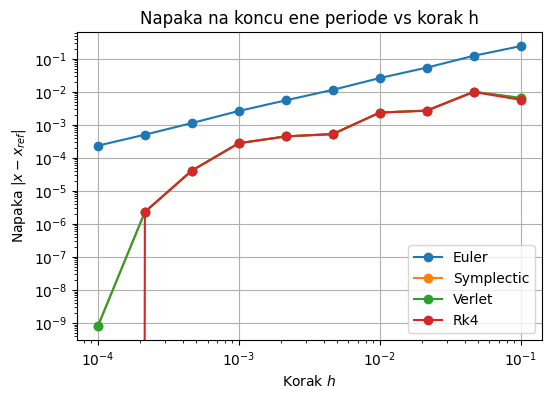

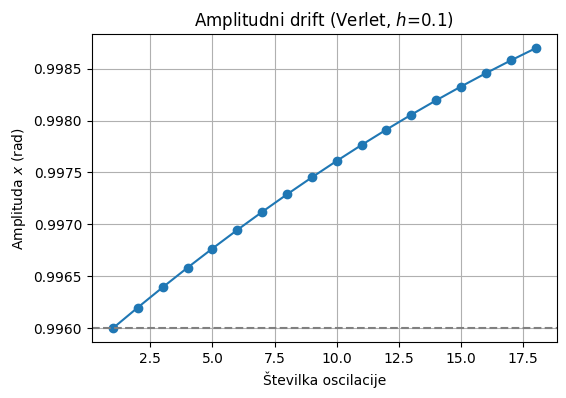

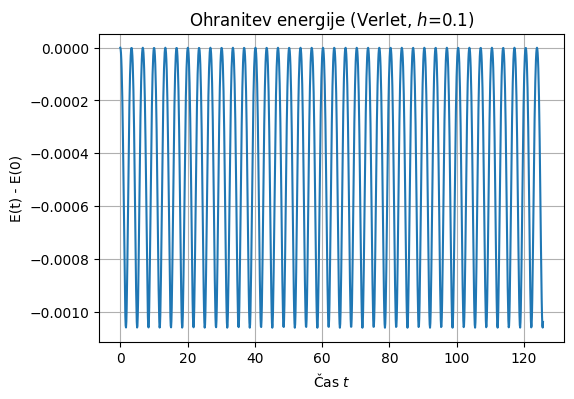

Pragovni koraki za napako <=10^-3:
Euler       : 2.15e-04
Symplectic  : 4.64e-03
Verlet      : 4.64e-03
Rk4         : 4.64e-03


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def pendulum_rhs(y):
    x, v = y
    return np.array([v, -np.sin(x)])

def simulate(method, h, t_max, y0):
    N = int(np.ceil(t_max / h))
    t = np.linspace(0, N*h, N+1)
    y = np.zeros((N+1, 2))
    y[0] = y0
    if method == 'euler':
        for i in range(N):
            y[i+1] = y[i] + h * pendulum_rhs(y[i])
    elif method == 'symplectic':
        for i in range(N):
            x, v = y[i]
            v_half = v - 0.5 * h * np.sin(x)
            x_new = x + h * v_half
            v_new = v_half - 0.5 * h * np.sin(x_new)
            y[i+1] = [x_new, v_new]
    elif method == 'verlet':
        x, v = y0
        for i in range(N):
            a = -np.sin(x)
            x_new = x + v*h + 0.5*a*h**2
            a_new = -np.sin(x_new)
            v_new = v + 0.5*(a + a_new)*h
            y[i+1] = [x_new, v_new]
            x, v = x_new, v_new
    elif method == 'rk4':
        for i in range(N):
            k1 = pendulum_rhs(y[i])
            k2 = pendulum_rhs(y[i] + 0.5*h*k1)
            k3 = pendulum_rhs(y[i] + 0.5*h*k2)
            k4 = pendulum_rhs(y[i] + h*k3)
            y[i+1] = y[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return t, y

y0 = np.array([1.0, 0.0])
T = 2*np.pi 
h_values = np.logspace(-1, -4, 10)
methods = ['euler', 'symplectic', 'verlet', 'rk4']

t_ref, y_ref = simulate('rk4', 1e-4, T, y0)
x_ref = y_ref[-1, 0]

errors = {m: [] for m in methods}
for h in h_values:
    for m in methods:
        _, y_sim = simulate(m, h, T, y0)
        errors[m].append(abs(y_sim[-1, 0] - x_ref))

thresholds = {}
for m in methods:
    idx = np.where(np.array(errors[m]) <= 1e-3)[0]
    thresholds[m] = h_values[idx[0]] if len(idx)>0 else None

plt.figure(figsize=(6,4))
for m in methods:
    plt.loglog(h_values, errors[m], 'o-', label=m.capitalize())
plt.xlabel('Korak $h$')
plt.ylabel('Napaka $|x - x_{ref}|$')
plt.title('Napaka na koncu ene periode vs korak h')
plt.legend()
plt.grid(True)
plt.savefig('pendulum_error.png', dpi=300)

h0 = 0.1
t_long, y_long = simulate('verlet', h0, 20*T, y0)
x_vals, v_vals = y_long[:,0], y_long[:,1]
peaks = []
for i in range(1, len(v_vals)-1):
    if v_vals[i-1] > 0 and v_vals[i] > 0 and v_vals[i+1] < 0:
        peaks.append(x_vals[i])
osc = np.arange(1, len(peaks)+1)

plt.figure(figsize=(6,4))
plt.plot(osc, peaks, 'o-')
plt.axhline(peaks[0], color='gray', linestyle='--')
plt.xlabel('Številka oscilacije')
plt.ylabel('Amplituda $x$ (rad)')
plt.title(f'Amplitudni drift (Verlet, $h$={h0})')
plt.grid(True)
plt.savefig('pendulum_amplitude_drift.png', dpi=300)

def energy(y):
    x, v = y.T
    return 1 - np.cos(x) + 0.5*v**2

E = energy(y_long)
plt.figure(figsize=(6,4))
plt.plot(t_long, E - E[0])
plt.xlabel('Čas $t$')
plt.ylabel('E(t) - E(0)')
plt.title(f'Ohranitev energije (Verlet, $h$={h0})')
plt.grid(True)
plt.savefig('pendulum_energy.png', dpi=300)

plt.show()


print("Pragovni koraki za napako <=10^-3:")
for m, h_thr in thresholds.items():
    print(f"{m.capitalize():12s}: {h_thr:.2e}" if h_thr else f"{m.capitalize():12s}: ni dosežen")


Optimalni kot (brez vetra): 42°
Optimalni kot (z vetrom=(5.0, 2.0) in Coriolis): 43°


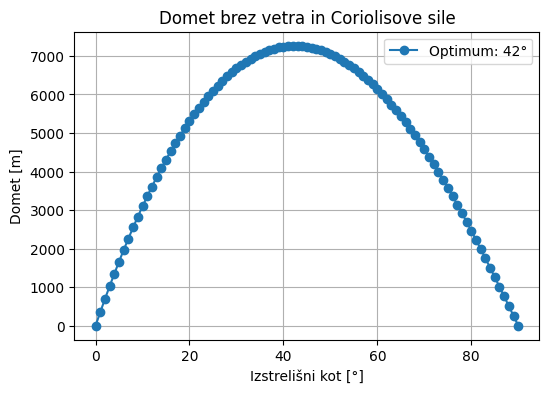

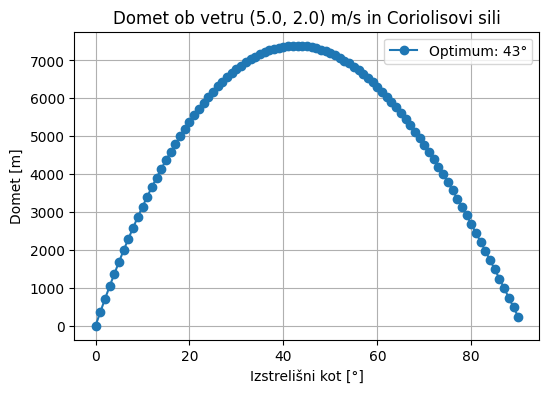

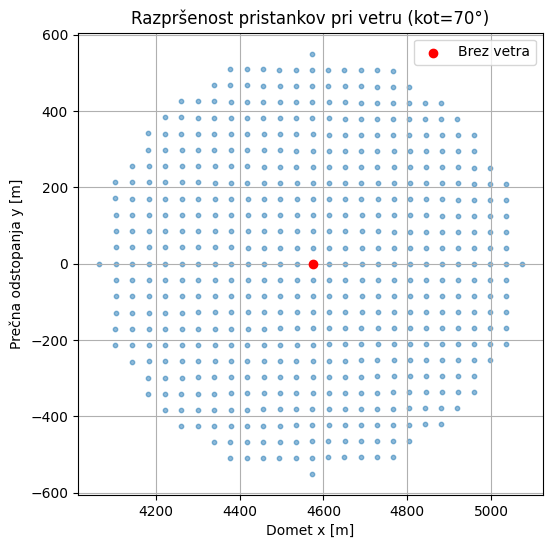

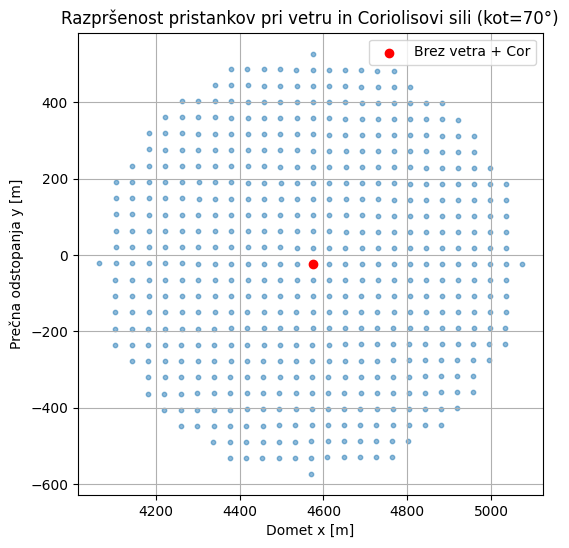

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

m = 35.0                # masa projektila (kg)
v0 = 316.0              # izstrelišna hitrost (m/s)
g = 9.80665             # gravitacija 
rho = 1.28              # gostota zraka (kg/m^3)
A = 0.0030              # presečna površina (m^2)
c_drag = 1.0            # koeficient upora
k = 0.5 * c_drag * rho * A
B = k / m

omega = 0.00007292      # kotna hitrost Zemlje (rad/s)
latitude = np.radians(46.0)  # geografska širina (rad)

c_max = 13.0
wind_vectors = [(u, v)
                for u in range(-int(c_max), int(c_max)+1)
                for v in range(-int(c_max), int(c_max)+1)
                if np.hypot(u, v) <= c_max]

def simulate(angle_deg, wind=(0,0), coriolis=False):
    u0 = (
        0.0,
        v0 * np.cos(np.radians(angle_deg)) + wind[0],
        0.0,
        wind[1],
        0.0,
        v0 * np.sin(np.radians(angle_deg))
    )
    def deriv(t, u):
        x, vx, y, vy, z, vz = u
        speed = np.hypot(np.hypot(vx, vy), vz)
        ax = - (k/m) * speed * vx
        ay = - (k/m) * speed * vy
        az = - (k/m) * speed * vz - g
        if coriolis:
            ax +=  2 * omega * vy * np.sin(latitude)
            ay += -2 * omega * (vz * np.cos(latitude) + vx * np.sin(latitude))
            az +=  2 * omega * vy * np.sin(latitude)
        return [vx, ax, vy, ay, vz, az]

    def hit_ground(t, u):
        return u[4]  # z
    hit_ground.terminal = True
    hit_ground.direction = -1

    sol = solve_ivp(deriv, (0, 600), u0, events=hit_ground, max_step=0.5)
    x_imp = sol.y[0, -1]
    y_imp = sol.y[2, -1]
    return x_imp, y_imp

# Domet kot funkcija kota brez vetra, brez Cor
angles = np.arange(0, 91)
ranges_no_wind = np.array([simulate(a, wind=(0,0), coriolis=False)[0] for a in angles])
opt_a_no_wind = angles[np.argmax(ranges_no_wind)]

plt.figure(figsize=(6,4))
plt.plot(angles, ranges_no_wind, '-o', label=f'Optimum: {opt_a_no_wind}°')
plt.xlabel('Izstrelišni kot [°]')
plt.ylabel('Domet [m]')
plt.title('Domet brez vetra in Coriolisove sile')
plt.grid(True)
plt.legend()
plt.savefig('projectile_range_no_wind.png', dpi=300)

# Domet kot funkcija kota z izbranim vetrom in Cor
wind_example = (5.0, 2.0)  # primer vetra (m/s)
ranges_wind_cor = np.array([simulate(a, wind=wind_example, coriolis=True)[0] for a in angles])
opt_a_wind_cor = angles[np.argmax(ranges_wind_cor)]

plt.figure(figsize=(6,4))
plt.plot(angles, ranges_wind_cor, '-o', label=f'Optimum: {opt_a_wind_cor}°')
plt.xlabel('Izstrelišni kot [°]')
plt.ylabel('Domet [m]')
plt.title(f'Domet ob vetru {wind_example} m/s in Coriolisovi sili')
plt.grid(True)
plt.legend()
plt.savefig('projectile_range.png', dpi=300)

print(f'Optimalni kot (brez vetra): {opt_a_no_wind}°')
print(f'Optimalni kot (z vetrom={wind_example} in Coriolis): {opt_a_wind_cor}°')

# Razpršenost pristankov ob upoštevanju vetra (brez Cor)
X2V, Y2V = zip(*(simulate(70, wind=w, coriolis=False) for w in wind_vectors))
plt.figure(figsize=(6,6))
plt.scatter(X2V, Y2V, s=10, alpha=0.5)
plt.scatter(simulate(70, wind=(0,0), coriolis=False)[0],
            simulate(70, wind=(0,0), coriolis=False)[1],
            color='red', label='Brez vetra', zorder=3)
plt.xlabel('Domet x [m]')
plt.ylabel('Prečna odstopanja y [m]')
plt.title('Razpršenost pristankov pri vetru (kot=70°)')
plt.legend()
plt.grid(True)
plt.savefig('projectile_scatter_no_cor.png', dpi=300)

# Razpršenost pristankov ob vetru in Cor
X3C, Y3C = zip(*(simulate(70, wind=w, coriolis=True) for w in wind_vectors))
plt.figure(figsize=(6,6))
plt.scatter(X3C, Y3C, s=10, alpha=0.5)
plt.scatter(simulate(70, wind=(0,0), coriolis=True)[0],
            simulate(70, wind=(0,0), coriolis=True)[1],
            color='red', label='Brez vetra + Cor', zorder=3)
plt.xlabel('Domet x [m]')
plt.ylabel('Prečna odstopanja y [m]')
plt.title('Razpršenost pristankov pri vetru in Coriolisovi sili (kot=70°)')
plt.legend()
plt.grid(True)
plt.savefig('projectile_scatter.png', dpi=300)
plt.show()
